<a href="https://colab.research.google.com/github/AshwinSaklecha/neoSapiensColab/blob/main/neoSapiens2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [3]:
# Load the data
url = "https://docs.google.com/spreadsheets/d/1iUd_HFOKm287Vd0VXyVsTNQRCkBzWBrh3co_uthaRNA/gviz/tq?tqx=out:csv&gid=386998417"
df = pd.read_csv(url)

In [4]:
df.head()

,timestamp,endpoint,user_id,response_time_ms,status_code
0,2024-12-01 23:20:31,/api/search,user_25,98,200
1,2024-12-01 23:25:31,/api/recommendations,user_82,107,200
2,2024-12-01 23:30:31,/api/chat,user_89,147,200
3,2024-12-01 23:35:31,/api/search,user_12,96,200
4,2024-12-01 23:40:31,/api/search,user_15,98,200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   timestamp         2016 non-null   object
 1   endpoint          2016 non-null   object
 2   user_id           2016 non-null   object
 3   response_time_ms  2016 non-null   int64 
 4   status_code       2016 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.9+ KB


In [ ]:
df.shape

(2016, 5)

In [ ]:
df.describe()

,response_time_ms,status_code
count,2016.000000,2016.000000
mean,419.240575,215.714286
std,2961.986796,63.129672
min,70.000000,200.000000
25%,97.000000,200.000000
50%,117.000000,200.000000
75%,145.000000,200.000000
max,30000.000000,504.000000


In [17]:
df.isnull().sum()

,0
timestamp,0
endpoint,0
user_id,0
response_time_ms,0
status_code,0
hour,0


In [18]:
df.duplicated().sum()

0

In [15]:
# Group by endpoint to calculate metrics

performance_metrics = df.groupby('endpoint').agg({
    'response_time_ms': [
        ('avg_response_time', 'mean'),
        ('p95_response_time', lambda x: np.percentile(x, 95)),
        ('requests_count', 'count')
    ]
}).round(2)

# flattening column names
performance_metrics.columns = performance_metrics.columns.droplevel()
performance_metrics


,avg_response_time,p95_response_time,requests_count
endpoint,,,
/api/chat,445.03,235.65,528
/api/recommendations,348.31,155.20,497
/api/search,471.61,157.90,495
/api/user/profile,410.60,160.00,496


In [16]:
# calculating error rates per endpoint
error_rates = df[df['status_code'] >= 400].groupby('endpoint').size()
total_requests = df.groupby('endpoint').size()
error_rate_pct = (error_rates / total_requests * 100).round(2).fillna(0)

# add error rate to metrics
performance_metrics['error_rate_pct'] = error_rate_pct

performance_metrics


,avg_response_time,p95_response_time,requests_count,error_rate_pct
endpoint,,,,
/api/chat,445.03,235.65,528,5.87
/api/recommendations,348.31,155.20,497,6.64
/api/search,471.61,157.90,495,6.87
/api/user/profile,410.60,160.00,496,4.84


In [20]:
# Convert timestamp to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(5)


,timestamp,endpoint,user_id,response_time_ms,status_code,hour
0,2024-12-01 23:20:31,/api/search,user_25,98,200,23
1,2024-12-01 23:25:31,/api/recommendations,user_82,107,200,23
2,2024-12-01 23:30:31,/api/chat,user_89,147,200,23
3,2024-12-01 23:35:31,/api/search,user_12,96,200,23
4,2024-12-01 23:40:31,/api/search,user_15,98,200,23


In [22]:
# Resample data to 1-hour intervals and calculate mean response time
df_hourly = df.set_index('timestamp').groupby([
    pd.Grouper(freq='1H'),
    'endpoint'
])['response_time_ms'].mean().reset_index()

df_hourly.head()


<ipython-input-22-04b02e28a1e7>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(freq='1H'),


,timestamp,endpoint,response_time_ms
0,2024-12-01 23:00:00,/api/chat,160.333333
1,2024-12-01 23:00:00,/api/recommendations,106.000000
2,2024-12-01 23:00:00,/api/search,97.333333
3,2024-12-02 00:00:00,/api/chat,140.000000
4,2024-12-02 00:00:00,/api/recommendations,90.000000


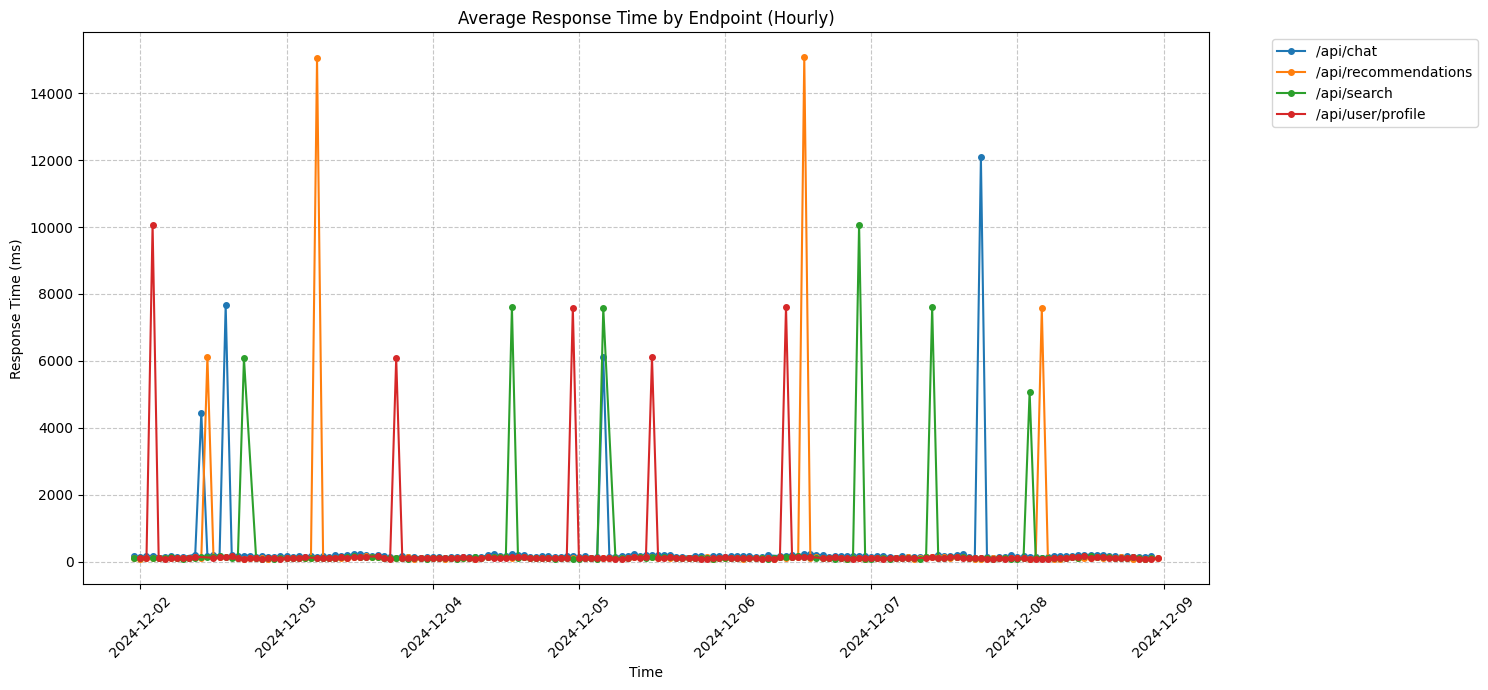

In [23]:

# Create the time series plot
plt.figure(figsize=(15, 7))

# Plot each endpoint
for endpoint in df_hourly['endpoint'].unique():
    endpoint_data = df_hourly[df_hourly['endpoint'] == endpoint]
    plt.plot(endpoint_data['timestamp'],
             endpoint_data['response_time_ms'],
             label=endpoint,
             marker='o',
             markersize=4)

plt.title('Average Response Time by Endpoint (Hourly)', fontsize=12)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Response Time (ms)', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

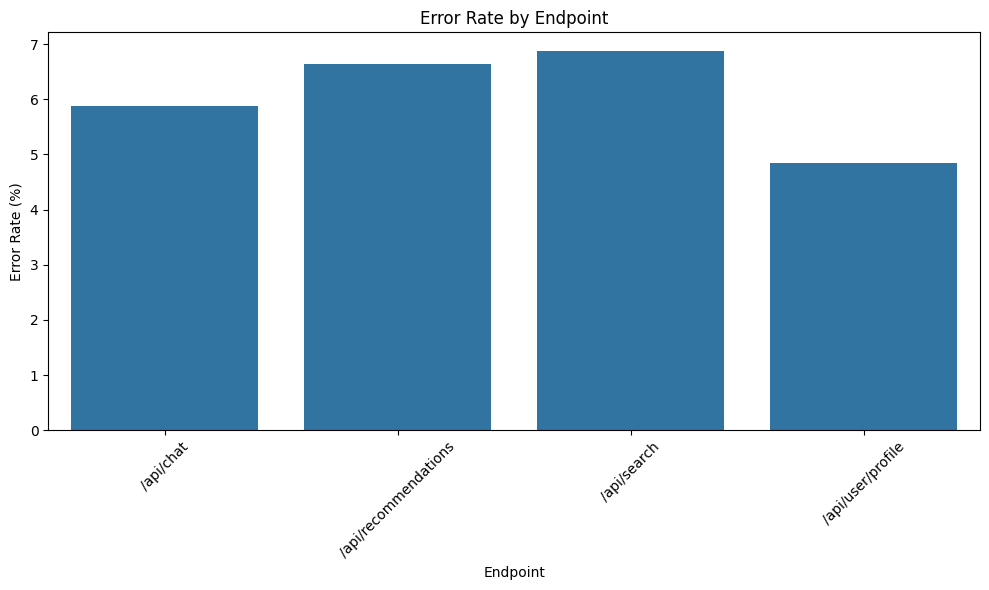

In [24]:
# Calculate error rates per endpoint
error_data = df.groupby('endpoint').agg({
    'status_code': lambda x: (x >= 400).mean() * 100
}).reset_index()

# Create the error rate plot
plt.figure(figsize=(10, 6))
sns.barplot(x='endpoint', y='status_code', data=error_data)
plt.title('Error Rate by Endpoint')
plt.xlabel('Endpoint')
plt.ylabel('Error Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Calculate mean and standard deviation for each endpoint
endpoint_stats = df.groupby('endpoint')['response_time_ms'].agg(['mean', 'std'])

# Initialize list to store anomaly data
anomalies = []

# Detect anomalies for each endpoint
for endpoint in df['endpoint'].unique():
    endpoint_data = df[df['endpoint'] == endpoint]
    mean = endpoint_stats.loc[endpoint, 'mean']
    std = endpoint_stats.loc[endpoint, 'std']

    # Find anomalies where response time > mean + threshold * std
    anomalous_requests = endpoint_data[
        endpoint_data['response_time_ms'] > (mean + 2 * std)  # Default threshold = 2
    ]

    if not anomalous_requests.empty:
        anomalies.append({
            'endpoint': endpoint,
            'anomaly_count': len(anomalous_requests),
            'total_requests': len(endpoint_data),
            'anomaly_percentage': round((len(anomalous_requests) / len(endpoint_data) * 100), 2)
        })

# Create a DataFrame for anomalies
anomalies_df = pd.DataFrame(anomalies)
anomalies_df

,endpoint,anomaly_count,total_requests,anomaly_percentage
0,/api/search,6,495,1.21
1,/api/recommendations,4,497,0.80
2,/api/chat,5,528,0.95
3,/api/user/profile,5,496,1.01


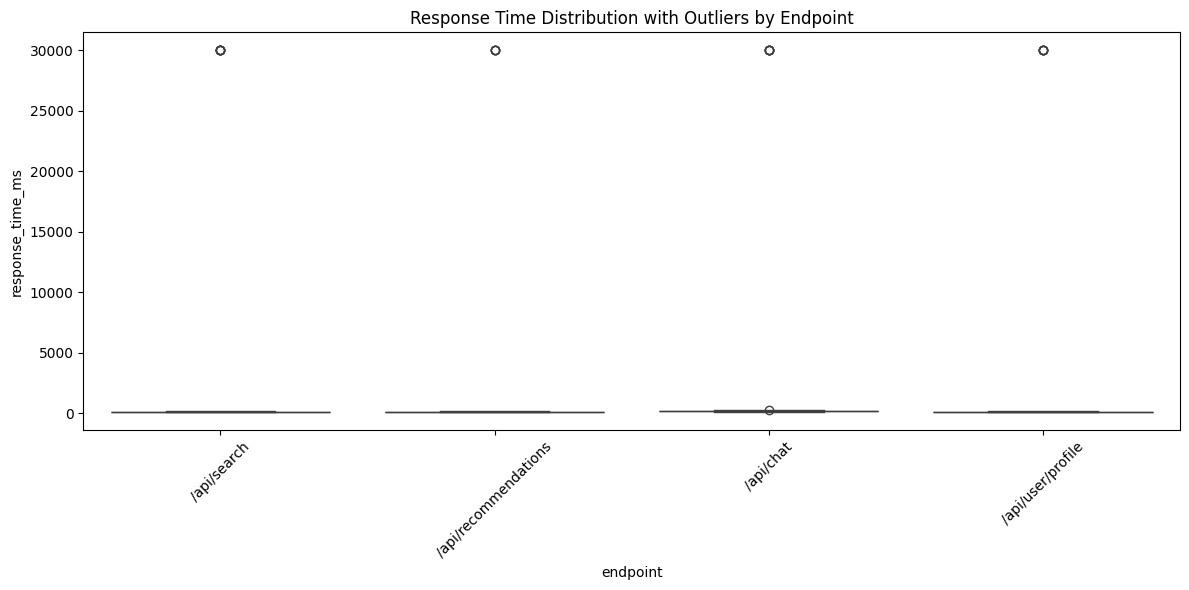

In [10]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
sns.boxplot(x='endpoint', y='response_time_ms', data=df)
plt.title('Response Time Distribution with Outliers by Endpoint')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# Convert timestamp to datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Add hour column
df['hour'] = df['timestamp'].dt.hour

df.head()

,timestamp,endpoint,user_id,response_time_ms,status_code,hour
0,2024-12-01 23:20:31,/api/search,user_25,98,200,23
1,2024-12-01 23:25:31,/api/recommendations,user_82,107,200,23
2,2024-12-01 23:30:31,/api/chat,user_89,147,200,23
3,2024-12-01 23:35:31,/api/search,user_12,96,200,23
4,2024-12-01 23:40:31,/api/search,user_15,98,200,23


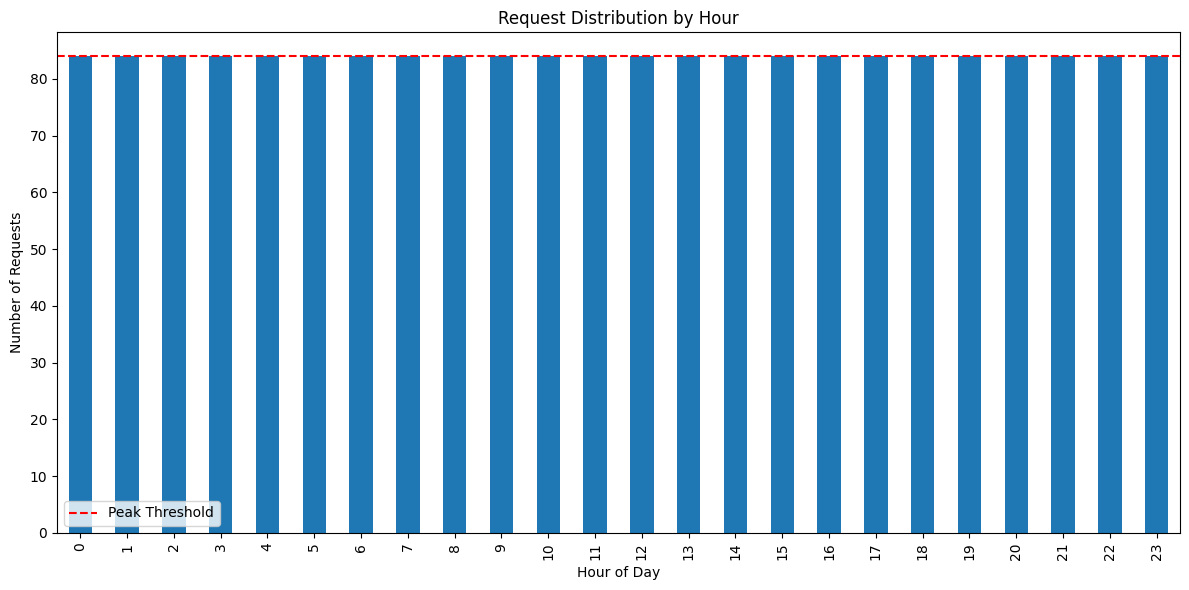

In [28]:
# Analyze requests per hour
hourly_usage = df.groupby('hour').size()

# Find peak hours
peak_threshold = hourly_usage.mean() + hourly_usage.std()
peak_hours = hourly_usage[hourly_usage >= peak_threshold]

# Visualize hourly distribution
plt.figure(figsize=(12, 6))
hourly_usage.plot(kind='bar')
plt.axhline(y=peak_threshold, color='r', linestyle='--', label='Peak Threshold')
plt.title('Request Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Requests')
plt.legend()
plt.tight_layout()
plt.show()

# Peak Usage Analysis
average_requests_per_hour = hourly_usage.mean()
peak_hours_summary = peak_hours
